In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch, torchvision 
from PIL import Image

In [3]:
import pywt
def cwt(signals,name='', width=10, wavelet_type = 'morl', vis=False):
    #print(signals.shape)
    # signals: channels x time
    num_steps = signals.shape[1]
    x = np.arange(num_steps) * 0.002
    delta_t = x[1] - x[0] # 500Hz 0.02s
    #print(delta_t)
    #Freq (5, 100)
    if wavelet_type == 'morl':
        scales = np.linspace(8,200,width)
    elif wavelet_type == 'mexh':
        scales = np.linspace(5,50,100)
    elif wavelet_type == 'gaus8':
        scales = np.linspace(12,120,100)
    else: # cmor
        scales = np.linspace(12,120,100)
    
    coef_norms = []
    for chn in list(range(12)):
        coef, freqs = pywt.cwt(signals[chn], scales, wavelet_type, delta_t)
        coef_norm = (coef-np.min(coef))/(np.max(coef) - np.min(coef))
        coef_norms.append(coef_norm)
        #np.save('../saved/cwt/'+name, coef)
        if vis:
            fig = plt.figure()
            ax = fig.add_subplot(211)
            plt.plot(x,signals[chn])

            ax = fig.add_subplot(212)
            #plt.matshow(coefs.astype(float)) 
            plt.imshow(coef.astype(float), aspect='auto', 
                       extent=(1, signals.shape[1], freqs[-1], freqs[0]), cmap='jet')
            plt.colorbar()
            #print((freqs[0], freqs[-1]))
           # plt.yticks(freqs)
            plt.suptitle(name  + ' ' +str(freqs[-1]) + ' '+  str(freqs[0]))
            plt.ylabel('Frequency(Hz)')
            plt.xlabel('Time(ms)')
            plt.savefig('../saved/figs/' + name + '_' + str(chn) + '.png')
            plt.close()
        
    return np.array(coef_norms)

In [4]:
# df_infos2 = pd.read_csv('../saved/infos2.csv')

In [5]:
import pickle
with open('../saved/datas.pkl', 'rb') as f:
    datas = pickle.load(f)

In [6]:
with open('../saved/header_datas.pkl', 'rb') as f:
    header_datas = pickle.load(f)

In [7]:
from global_vars import labels
def get_basic_info(header_data, labels, i):
    tmp_hea = header_data[0].split(' ')
    ptID = tmp_hea[0]
    age = None
    sex = None
    label = None
    Dx = None
    for iline in header_data:
        if iline.startswith('#Age'):
            tmp_age = iline.split(': ')[1].strip()
            age = int(tmp_age if tmp_age != 'NaN' else 57)
        elif iline.startswith('#Sex'):
            tmp_sex = iline.split(': ')[1]
            if tmp_sex.strip()=='Female':
                sex =1
            else:
                sex=0
        elif iline.startswith('#Dx'):
            Dx = np.char.rstrip(iline.split(': ')[1].split(','))
            label = [ll in Dx for ll in labels]
            
    
    return [ptID, sex, age, ' '.join(Dx), i] + label

In [8]:
from scipy import signal 

def butter_bandpass(lowcut, highcut, fs, order=5, vis=False):
    nyq = 0.5 * fs # fs / 2
    low = lowcut / nyq # lowcut * 2 / fs
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    # visualize the filter
    if vis:
        w, h = signal.freqz(b, a, worN=2000)
        plt.plot((fs * 0.5 / np.pi) * w, abs(h), label="order = %d" % order) # fs / (2 * pi)
        plt.title('Butterworth filter frequency response')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Gain')
        plt.margins(0, 0.1)
        plt.grid(which='both', axis='both')
        plt.axvline(low, color='green') # cutoff frequency
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    # lowcut, fs in Hz
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = signal.filtfilt(b, a, data)
    
    return y

def filter_data(Data, highcut=None):
    Data_filtered = np.zeros(Data.shape)
    chns = Data.shape[0]
    for chn in range(chns):
        if highcut is None:
            filtered_ecg = butter_bandpass_filter(Data[chn,:], lowcut=0.5,
                                                  highcut=30.0, fs=500.0,
                                                  order=4)
            Data_filtered[chn, :] = filtered_ecg
        else:
            filtered_ecg = butter_bandpass_filter(Data[chn,:], lowcut=0.5,
                                                  highcut=highcut, fs=500.0,
                                                  order=4)
            Data_filtered[chn, :] = filtered_ecg            

    return Data_filtered

In [9]:
import matplotlib.pyplot as plt
cmap = plt.get_cmap('jet')
import time, pickle
#infos = []


data_imgs = []
infos_all = []
#pathologies = []
for i in tqdm(range(len(datas)), leave=False, desc='compute'):#fDataReNorms.shape[0])): #

    info = get_basic_info(header_datas[i], labels, i)
#     if str(info[3]) in pathologies:
#         continue
#     pathologies.append(str(info[3]))
    
   
    data = datas[i]
    n_segments = int(data.shape[1]/3000)
    resize = torchvision.transforms.Resize((224, n_segments*224))
    fData = filter_data(data[:,:n_segments*3000], highcut=50.0)
    
    coef = cwt(fData, width=224, name=str(i)+' '+str(info[3]), vis=False) # str(i)+' '+str(info[3])
    coef = coef.transpose((1,2,0))
    data_img0 = Image.fromarray((coef[:,:,:3] * 255).astype(np.uint8)) 
    data_img1 = Image.fromarray((coef[:,:,3:6] * 255).astype(np.uint8)) 
    data_img2 = Image.fromarray((coef[:,:,6:9] * 255).astype(np.uint8)) 
    data_img3 = Image.fromarray((coef[:,:,9:12] * 255).astype(np.uint8)) 
    data_imgs.append([resize(data_img0), 
                      resize(data_img1), 
                      resize(data_img2), 
                      resize(data_img3)])
    infos_all.append(info)

In [10]:
len(infos_all)

[['A0001',
  0,
  74,
  'RBBB',
  0,
  False,
  False,
  False,
  False,
  False,
  False,
  True,
  False,
  False],
 ['A0002',
  1,
  49,
  'Normal',
  1,
  False,
  False,
  False,
  True,
  False,
  False,
  False,
  False,
  False],
 ['A0003',
  1,
  81,
  'AF',
  2,
  True,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False],
 ['A0004',
  0,
  45,
  'AF',
  3,
  True,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False],
 ['A0005',
  0,
  53,
  'PVC',
  4,
  False,
  False,
  False,
  False,
  False,
  True,
  False,
  False,
  False],
 ['A0006',
  0,
  29,
  'RBBB',
  5,
  False,
  False,
  False,
  False,
  False,
  False,
  True,
  False,
  False],
 ['A0007',
  0,
  74,
  'AF',
  6,
  True,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False],
 ['A0008',
  1,
  80,
  'STD',
  7,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  True,
  False],
 ['A0009',
  0,
  81,
  'AF',
  8,
  True,
  False,
  False,
 

In [11]:
#     with open('../saved/data_imgs2.pkl', 'wb') as f:
#         pickle.dump(data_imgs, f)

In [13]:
len(data_imgs)

6877

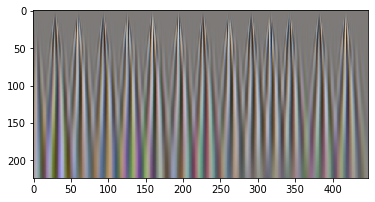

In [12]:
plt.imshow(data_imgs[5][3])

In [38]:
data_img0_a.shape

(12, 224, 3)

In [29]:
lengths = [data.shape[1] for data in datas]
max(lengths)

72000

In [11]:
coef.shape

(12, 224, 3000)

In [12]:
df_infos = pd.DataFrame(infos_all, columns=['ptID','Sex','Age','Dx', 'idx']+labels)
df_infos.to_csv('../saved/infos4.csv')

In [11]:
# read the data
data_imgs = []
for i in tqdm_notebook(range(len(df_infos2))):
    with Image.open('../saved/data_imgs/0/'+str(i)+'.png') as img:
        data_imgs.append(img.copy())

/home/yfeng/anaconda3/envs/physioNet/lib/python3.6/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


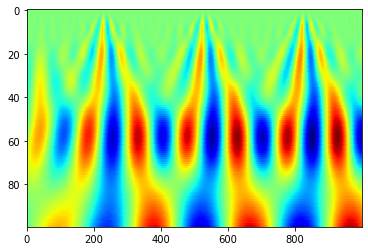

In [48]:
plt.imshow(coef[:,:1000], aspect='auto', cmap='jet')

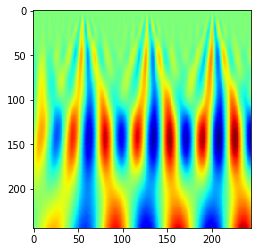

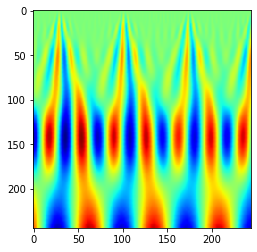

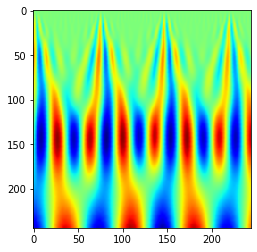

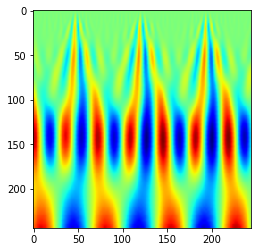

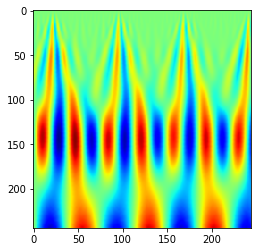

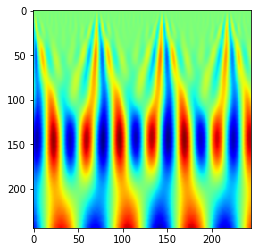

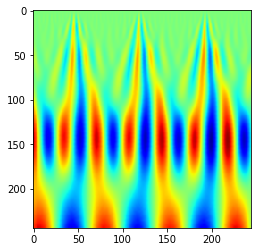

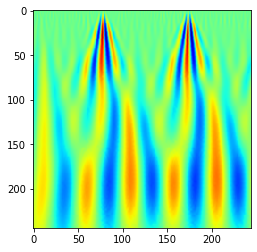

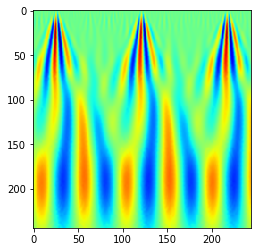

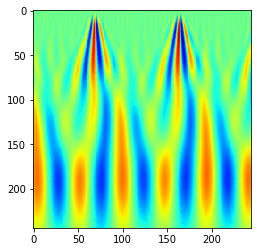

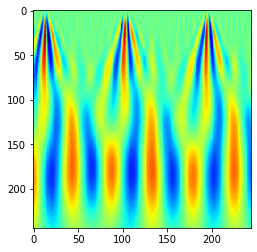

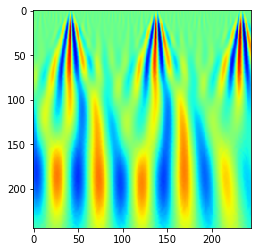

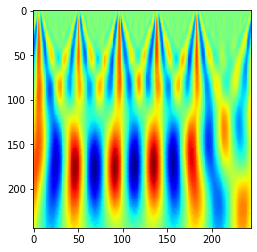

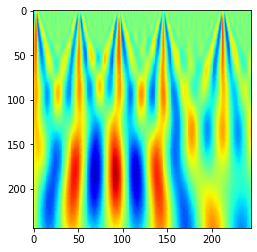

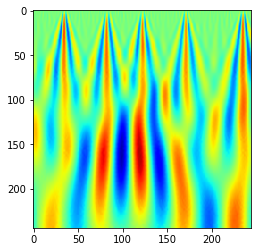

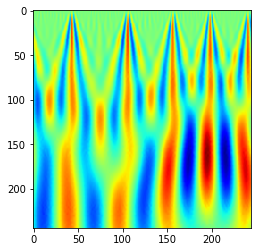

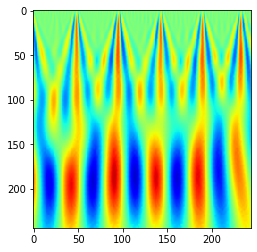

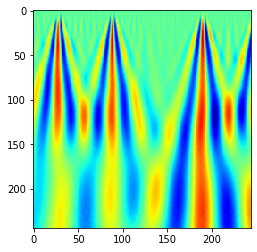

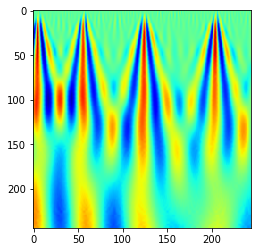

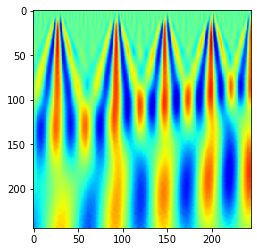

In [ ]:
for data_img in data_imgs:
    plt.imshow(data_img) 
    plt.show()